## **Linear Regression for Classification: Performance Evaluation on the Seeds Dataset**


### Dataset Selection and Preparation
The dataset is obtained from the UCI Machine Learning Repository: [Seeds Dataset - UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/236/seeds).
It was created as part of an agricultural study to classify wheat seeds into different varieties based on their 7 morphological features, measured using a soft X-Ray technique. The dataset was originally intended for classification tasks, making it well-suited for exploring how linear regression can be adapted for classification.

The dataset consists of 210 samples (70 samples per class) belonging to one of three classes. The classes (target variable) were the 3 varieties of wheat (Kama, Rosa, and Canadian wheat). 

Each sample represents a single wheat kernel, described by seven features:
- Area (A)
- Perimeter (P)
- Compactness (C) = 4πA / P²
- Length of Kernel
- Width of Kernel
- Asymmetry Coefficient
- Length of Kernel Groove

The target variable was originally encoded by integers, where
- 1 = Kama Wheat
- 2 = Rosa Wheat
- 3 = Canadian Wheat

In this report, I evaluated 2 linear regression models to classify the data into 3 classes of wheat:
1. Linear Regression utilizing all 7 features available in the dataset
2. Linear Regression utilizing only 2 features from the dataset: Area (A) and Length of Kernel Groove.

Part 1 consists of my annotated code. Part 2 is a more formal write-up and report where I interpret the results of the model, primarily focusing on the 2nd model I conducted (the one that only utilized two features).

In [1]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import statsmodels.api as sm

# Visualization
import seaborn as sns

## Importing and Preprocessing the Data

The "seeds" dataset was imported into the working environment to enable feature labeling and species name mapping. These initial steps ensure the data aligns with its original context as defined by the authors of the associated white paper.

In [2]:
# Data Import

file_path = 'C:/Users/Sferg/OneDrive/Desktop/Illinois Tech/3_Spring A 2025/2_Statistical_Learning/Datasets/seeds/seeds_dataset.txt'

# Replace 'your_data_file.txt' with the path to your file
mydata = pd.read_csv(file_path, delimiter='/t')
print(mydata)

     15.26\t14.84\t0.871\t5.763\t3.312\t2.221\t5.22\t1
0    14.88\t14.57\t0.8811\t5.554\t3.333\t1.018\t4.9...
1    14.29\t14.09\t0.905\t5.291\t3.337\t2.699\t4.82...
2    13.84\t13.94\t0.8955\t5.324\t3.379\t2.259\t4.8...
3    16.14\t14.99\t0.9034\t5.658\t3.562\t1.355\t5.1...
4    14.38\t14.21\t0.8951\t5.386\t3.312\t2.462\t4.9...
..                                                 ...
204  12.19\t13.2\t0.8783\t5.137\t2.981\t3.631\t4.87\t3
205  11.23\t12.88\t0.8511\t5.14\t2.795\t4.325\t5.00...
206  13.2\t13.66\t0.8883\t5.236\t3.232\t8.315\t5.05...
207  11.84\t13.21\t0.8521\t5.175\t2.836\t3.598\t5.0...
208  12.3\t13.34\t0.8684\t5.243\t2.974\t5.637\t5.06...

[209 rows x 1 columns]


C:\Users\Sferg\AppData\Local\Temp\ipykernel_21816\4198477691.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  mydata = pd.read_csv(file_path, delimiter='/t')


The raw dataset had no column headers and the species name (target variable) was ordinal encoded. 

Above, we also see that the first row of data is mistakenly identified as a header. That is easily fixed with the argument `header=None`. Additionally, we see that something strange is happening with the tab-separated values; the data is not importing correctly. Upon inspection of the raw .txt file, I observed 9 rows that had >1 tab separating each value, causing the data to import incorrectly. See image below: 3 instances where >1 tab separating data.
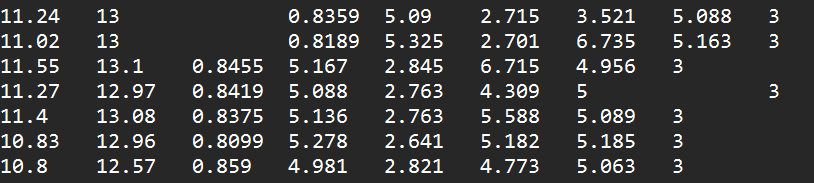

Below, two arguments were added upon import of the data:
1) The dataset was identified to have no header.
2) Import command now specifies that any whitespace is now a delimiter (even multiple consecutive tabs). This fixed the data import issue.


In [3]:
mydata = pd.read_csv(file_path, sep=r'\s+', header=None) #r'\s+' changed it to s+--any whitespace is now a delimiter (even two tabs)
print(mydata.head(10))

print('Number of Rows:', len(mydata))

       0      1       2      3      4      5      6  7
0  15.26  14.84  0.8710  5.763  3.312  2.221  5.220  1
1  14.88  14.57  0.8811  5.554  3.333  1.018  4.956  1
2  14.29  14.09  0.9050  5.291  3.337  2.699  4.825  1
3  13.84  13.94  0.8955  5.324  3.379  2.259  4.805  1
4  16.14  14.99  0.9034  5.658  3.562  1.355  5.175  1
5  14.38  14.21  0.8951  5.386  3.312  2.462  4.956  1
6  14.69  14.49  0.8799  5.563  3.259  3.586  5.219  1
7  14.11  14.10  0.8911  5.420  3.302  2.700  5.000  1
8  16.63  15.46  0.8747  6.053  3.465  2.040  5.877  1
9  16.44  15.25  0.8880  5.884  3.505  1.969  5.533  1
Number of Rows: 210


The first 10 rows appear to be importing correctly.\
Below, I'll check for null values; there should be none now.

In [4]:
# The number of null values in each column.
print(mydata.isnull().sum())

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
dtype: int64


This verifies that there are no null values in any of the columns (columns 0 through 7).

Next, I defined the feature names in my data frame for better interpretability. I also defined the mapped each ordinal target label with their descriptive names.

In [5]:
# Define the Actual Feature Names
data_labels = ['area_A', 'perimeter_P', 'compactness C=4*pi*A/P^2', 
                 'length_of_kernel', 'width_of_kernel', 'asymmetry_coefficient', 
                 'length_of_kernel_groove', 'kernel_species']

# Assign the feature names to the columns of the DataFrame
mydata.columns = data_labels

# Replaced numeric target labels with descriptive names
species_mapping = {1: 'Kama', 2: 'Rosa', 3: 'Canadian'} #This is how the authors encoded their categories--verified with the white paper
mydata['kernel_species'] = mydata['kernel_species'].replace(species_mapping)

print(mydata.head())

   area_A  perimeter_P  compactness C=4*pi*A/P^2  length_of_kernel  \
0   15.26        14.84                    0.8710             5.763   
1   14.88        14.57                    0.8811             5.554   
2   14.29        14.09                    0.9050             5.291   
3   13.84        13.94                    0.8955             5.324   
4   16.14        14.99                    0.9034             5.658   

   width_of_kernel  asymmetry_coefficient  length_of_kernel_groove  \
0            3.312                  2.221                    5.220   
1            3.333                  1.018                    4.956   
2            3.337                  2.699                    4.825   
3            3.379                  2.259                    4.805   
4            3.562                  1.355                    5.175   

  kernel_species  
0           Kama  
1           Kama  
2           Kama  
3           Kama  
4           Kama  


In [6]:
X = mydata.drop('kernel_species', axis=1)
Y = mydata['kernel_species']

# Perform a train test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 7)

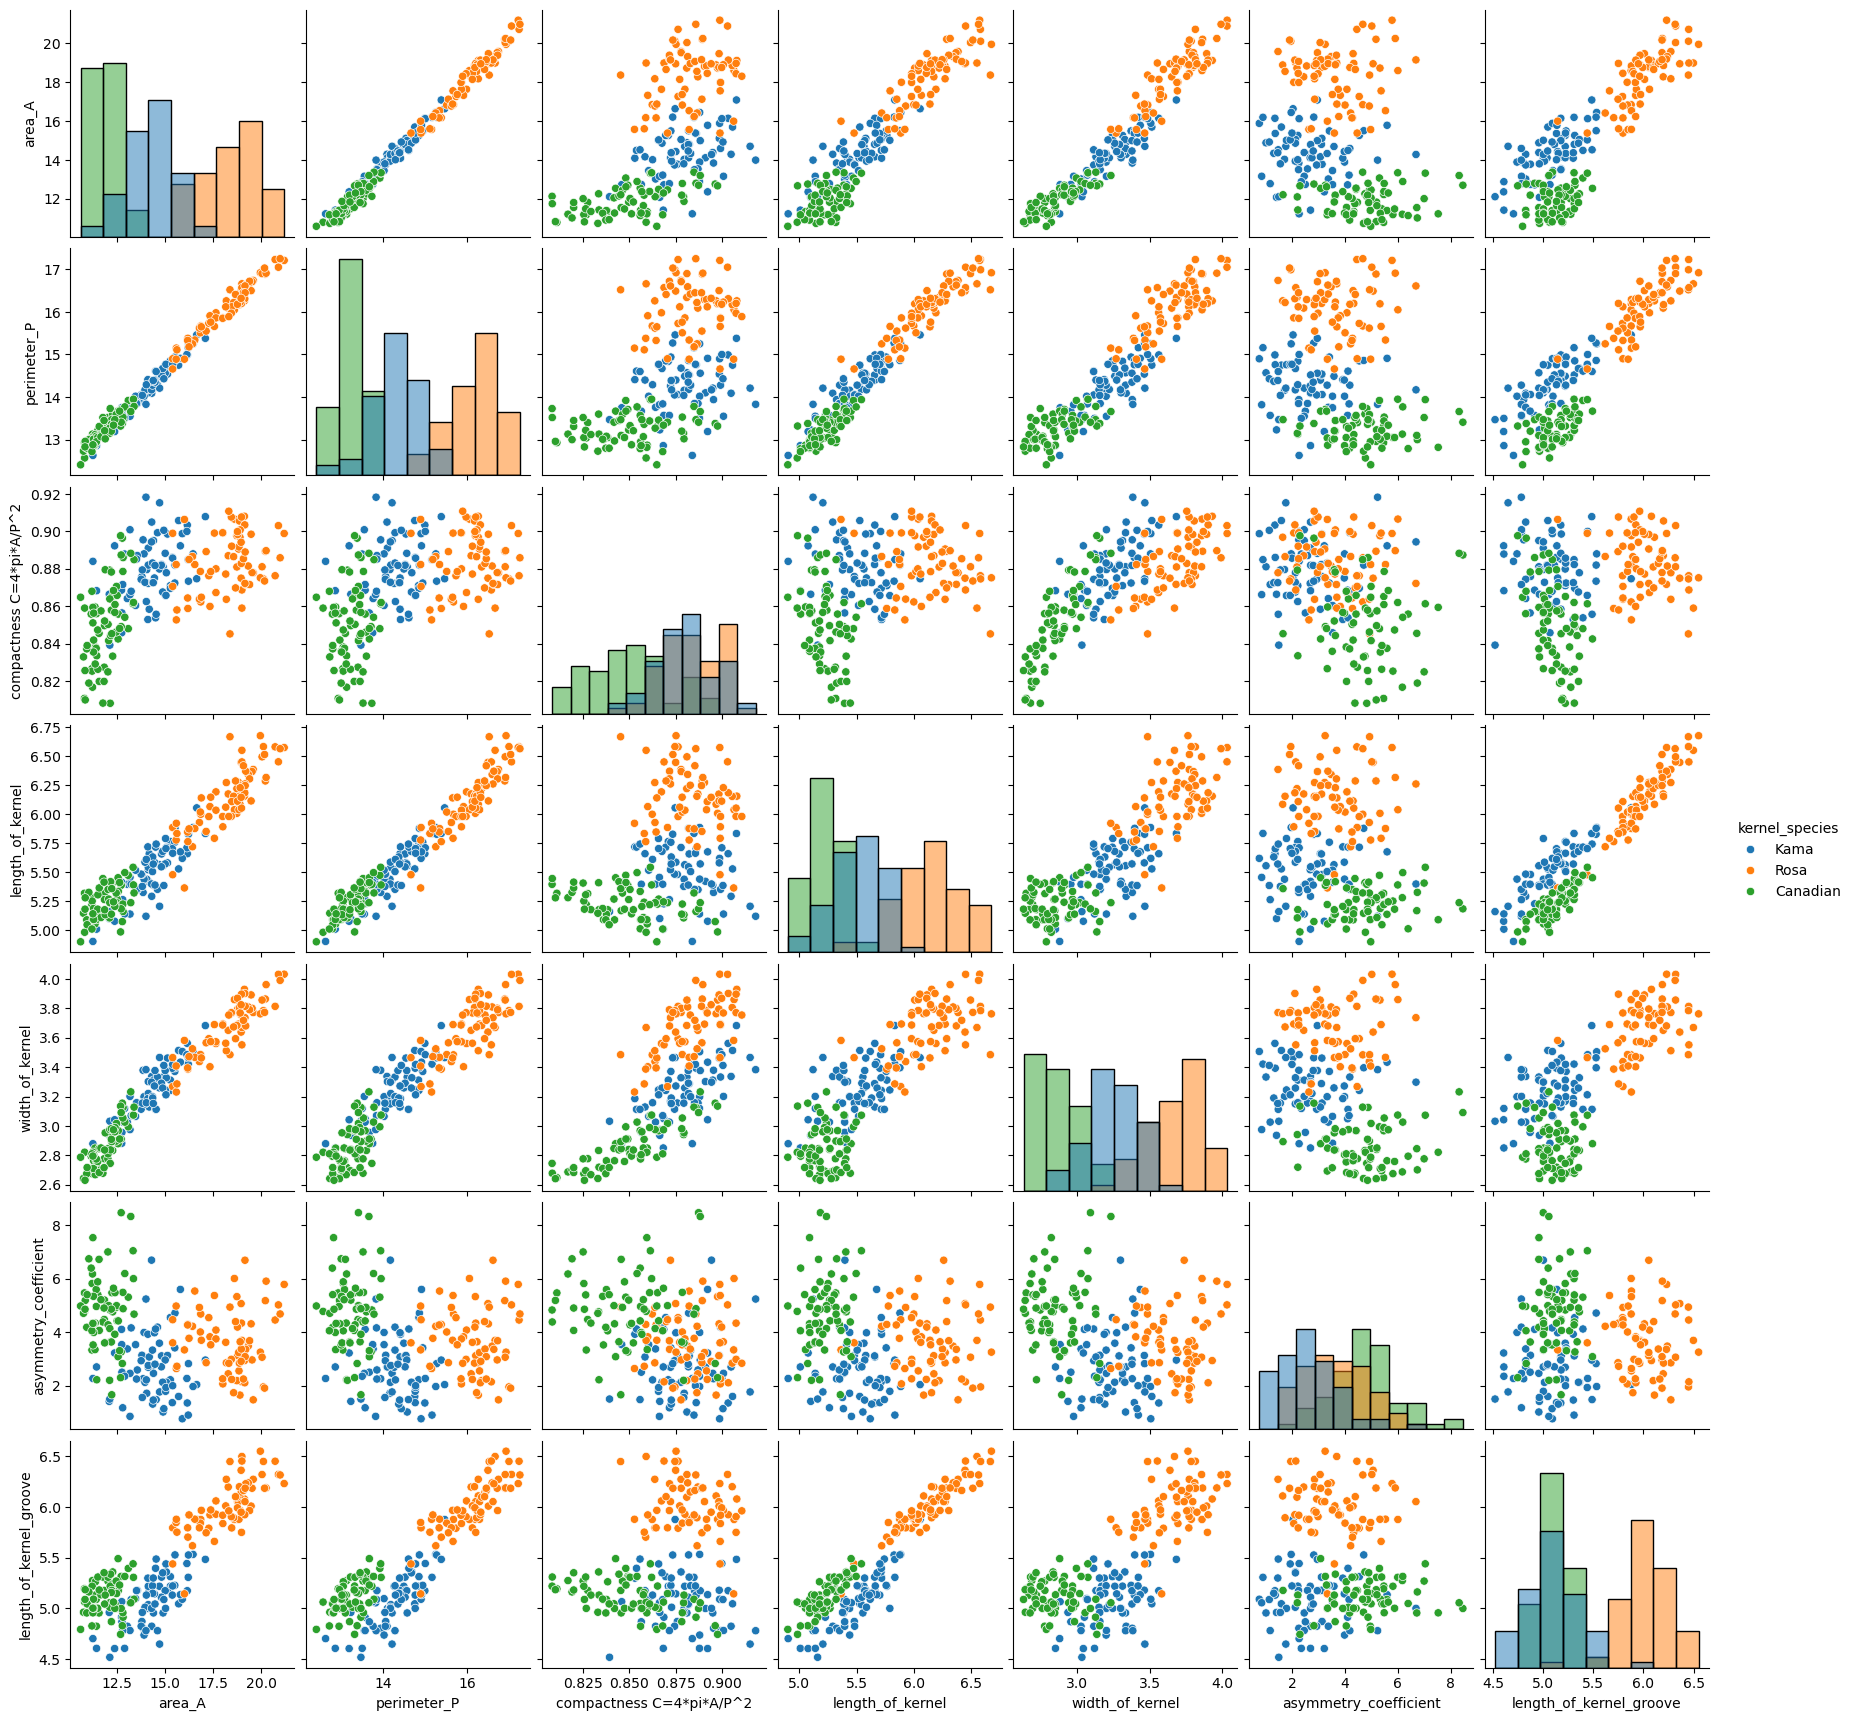

In [7]:
sns.pairplot(mydata, hue="kernel_species", diag_kind='hist')

In [8]:
# Train a Random Forest model

rf_model = RandomForestClassifier(random_state=7)
rf_model.fit(X_train, Y_train)

# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Combine feature names with their importance scores
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the most important features
print(importance_df)

                    Feature  Importance
6   length_of_kernel_groove    0.216430
0                    area_A    0.175893
1               perimeter_P    0.173631
4           width_of_kernel    0.158374
3          length_of_kernel    0.143486
5     asymmetry_coefficient    0.069486
2  compactness C=4*pi*A/P^2    0.062700


First, I'll run the linear regression model utilizing all of the 7 features provided in the dataset.

Then, I'll run the model utilizing only 2 features (the deemed most important by the random forest model, and corroborated with the pairwise plots (in the pairwise plots we can see good separation between the 3 species). Here we can see that `length_of_kernel_groove` and `area_A` have high importance scores. Therefore, a model based on these two features would be a good contender for generalizing the data.

In sum, two models: \
**Model 1.** Utilizes all 7 features available in the dataset \
**Model 2.** Utilizes only 2 features - `length_of_kernel_groove` and `area_A`

## Encode the Target data using One-Hot Encoding

  | Species | One-Hot Representation |
  |-------|-------|
  | Kama   | [1, 0, 0] |
  | Rosa  | [0, 1, 0] |
  | Canadian | [0, 0, 1] |

In [9]:
# Initialize OneHotEncoder
encoder = OneHotEncoder(categories=[['Kama', 'Rosa', 'Canadian']], sparse_output=False)
# I added the categories argument because the encoder by default will assign the codes alphabetically. 
# Therefore, Canadian would be [1. 0. 0.]. To avoid confusion, I wanted to maintain the order of the categories, 
# Where the order is as follows: kama, rosa, canadian

# Fit-transform Y_train and transform Y_test
Y_train_encoded = encoder.fit_transform(Y_train.values.reshape(-1,1)) #with -1, reshape will infer number of rows. with 1, reshape is set to have a single column
Y_test_encoded = encoder.transform(Y_test.values.reshape(-1,1))

print('Y_train_encoded (first 5 rows):')
print(Y_train_encoded[:5]) 

print('Y_test_encoded (first 5 rows):')
print(Y_test_encoded[:5])

Y_train_encoded (first 5 rows):
[[0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]
Y_test_encoded (first 5 rows):
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


## Model 1 : Linear Regression Utilizing All 7 Features

In [10]:
# Create and fit the Linear Regression  Model

# Initialize the Linear Model
model = LinearRegression()
# Fit the model to the training data
model.fit(X_train, Y_train_encoded)

LinearRegression()

In [11]:
# Compute coefficients
coef = model.coef_
intercept = model.intercept_
print(coef)
print(intercept)

[[-9.66254976e-01  1.79052648e+00  1.88884751e+01  2.04775712e+00
  -9.01722684e-02 -6.24644598e-02 -1.61852323e+00]
 [ 2.21871970e-01  5.63303140e-02 -6.04918543e+00 -1.68371092e+00
   2.08551743e-01  2.15047328e-03  9.33978723e-01]
 [ 7.44383006e-01 -1.84685679e+00 -1.28392897e+01 -3.64046198e-01
  -1.18379475e-01  6.03139865e-02  6.84544512e-01]]
[-30.08049098   5.21862664  25.86186434]


Since one-hot encoding was applied, the model creates separate equations for each species. Each equation shows how the input features relate to the encoded label for that species. The model then outputs continuous values, which estimate how likely each class (species) is for a given input. The class with the highest output value is chosen as the predicted class.

$$ \hat{Y}_{\text{Kama}} = -30.080 - 0.966X_1 + 1.791X_2 + 18.889X_3 + 2.048X_4 - 0.090X_5 - 0.062X_6 - 1.619X_7 $$

$$ \hat{Y}_{\text{Rosa}} = 5.219 + 0.222X_1 + 0.056X_2 - 6.049X_3 - 1.684X_4 + 0.209X_5 + 0.002X_6 + 0.934X_7 $$

$$ \hat{Y}_{\text{Canadian}} = 25.862 + 0.744X_1 - 1.847X_2 - 12.840X_3 - 0.364X_4 - 0.119X_5 + 0.060X_6 + 0.685X_7 $$

 $\beta_0$ is the intercept, and $\beta_1, \beta_2, \dots, \beta_7 \$ are the coefficients.

 - $X_1, X_2, \dots, X_7$ are the predictors:
  - $X_1$ : Area
  - $X_2$: Perimeter
  - $X_3$: Compactness
  - $X_4$: Length of kernel
  - $X_5$: Width of kernel
  - $X_6$: Asymmetry coefficient
  - $X_7$: Length of kernel groove


In [12]:
# Predict the One-hot encoded targets for the test set
Y_test_pred = model.predict(X_test)
Y_test_pred[:3]

# This is the output for the predictions. Highest number determines prediction
# column 0 corresponds with Kama, 1 with Rosa, 2 with Canadian. In row 1 we see column1 has highest value (0.92). Therefore 1 is the predicted class for this row

array([[-0.07186998,  0.91699693,  0.15487306],
       [ 1.05605301, -0.22849453,  0.17244152],
       [ 0.31482784,  0.6460902 ,  0.03908197]])

In [13]:
# Evaluate the model: Convert predictions back to class labels
# The predicted classes will correspond to the index of the max value in the one-hot vector
Y_test_pred_classes = np.argmax(Y_test_pred, axis=1)
Y_test_true_classes = np.argmax(Y_test_encoded, axis=1)
print('Y_test_pred_classes:', Y_test_pred_classes)
print('Y_test_true_classes:', Y_test_true_classes)

Y_test_pred_classes: [1 0 1 0 0 0 1 0 0 2 0 1 1 1 1 2 1 1 1 1 2 2 1 2 1 2 2 1 1 2 2 2 0 1 1 2 1
 0 1 0 2 1 1 2 2 2 0 2 0 0 0 0 2 0 2 1 0 0 2 2 1 0 0]
Y_test_true_classes: [1 0 1 0 0 0 1 0 0 2 0 1 1 1 1 2 1 1 1 1 2 2 1 2 1 2 2 1 1 2 2 2 0 1 1 2 1
 0 1 0 2 1 1 2 2 2 0 2 0 0 0 0 2 0 2 1 0 0 2 2 1 0 0]


In [14]:
# Calculate accuracy
accuracy = accuracy_score(Y_test_pred_classes, Y_test_true_classes)
print(f"Model Accuracy: {accuracy:.5f}")

Model Accuracy: 1.00000


In [15]:
print(classification_report(Y_test_pred_classes, Y_test_true_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        20

    accuracy                           1.00        63
   macro avg       1.00      1.00      1.00        63
weighted avg       1.00      1.00      1.00        63



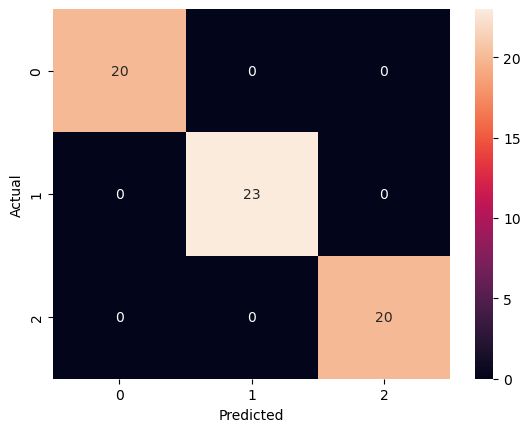

Accuracy: 1.0
Macro Precision: 1.0
Macro Recall: 1.0
Weighted Precision: 1.0
Weighted Recall: 1.0
Micro Precision: 1.0
Micro Recall: 1.0


In [16]:
# Calculate confusion matrix
confusion_matrix = pd.crosstab(Y_test_true_classes, Y_test_pred_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(Y_test_true_classes, Y_test_pred_classes)
print(f'Accuracy: {accuracy}')

precision_macro = precision_score(Y_test_true_classes, Y_test_pred_classes, average='macro')
recall_macro = recall_score(Y_test_true_classes, Y_test_pred_classes, average='macro')

precision_weighted = precision_score(Y_test_true_classes, Y_test_pred_classes, average='weighted')
recall_weighted = recall_score(Y_test_true_classes, Y_test_pred_classes, average='weighted')

precision_micro = precision_score(Y_test_true_classes, Y_test_pred_classes, average='micro')
recall_micro = recall_score(Y_test_true_classes, Y_test_pred_classes, average='micro')

print(f'Macro Precision: {precision_macro}')
print(f'Macro Recall: {recall_macro}')
print(f'Weighted Precision: {precision_weighted}')
print(f'Weighted Recall: {recall_weighted}')
print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')

I was not expecting a 100% accuracy. However, a high accuracy makes sense because we are using 7 predictors in our model. But, perhaps using 7 predictors is a bit overkill. The simplest effective model is often the best one. So, I'll simplify this model by reducing the number of predictors, choosing the two most important predictors as previously determined by the random forest model: `length_of_kernel_groove` and `area_A`.

Plus, with only 2 predictors, I can make some pretty 2-dimensional visualizations!

In [17]:
# Define a custom mapping of categories to numbers
category_mapping = {'Kama': 0, 'Rosa': 1, 'Canadian': 2}
species_names = list(category_mapping.keys())
Y_train_ordinal_encoded = Y_train.map(category_mapping)

# Determine if all features are important for predicting the label
X_sm = sm.add_constant(X_train)

smodel = sm.OLS(Y_train_ordinal_encoded, X_sm).fit()

The linear model can be expressed by the equation as follows:

$$ \hat{Y} = 56.942 + 1.711X_1 - 3.637X_2 - 31.723X_3 - 2.412X_4 - 0.0282X_5 + 0.123X_6 + 2.303X_7 $$
The F-statistic p-value is extremely low (5.12e-38), indicating that the model as a whole is statistically significant.

With a p value of 0.975, it can be concluded that the predictor `width_of_kernel` is not statistically significant: it does not provide additional explanatory power to the model that the other predictors don't already provide. Perhaps it is collinear with another predictor. I could drop this predictor and see how the model performs. However, since I already plan to reduce the number of predictors to two, I will skip this analysis.

## Model 2: Linear Regression with 2 Features

#### Any reference to "The model" refers to this one henceforth

#### length_of_kernel_groove, area_A

In [18]:
# Dynamically define the feature names
feature_1 = data_labels[6]
feature_2 = data_labels[0]

print('feature_1:', feature_1)
print('feature_2:', feature_2)

feature_1: length_of_kernel_groove
feature_2: area_A


In [19]:
# Subset the X_train and X_test data to only include 2 predictors
X_pairs_train = X_train[[feature_1, feature_2]]
X_pairs_test = X_test[[feature_1, feature_2]]

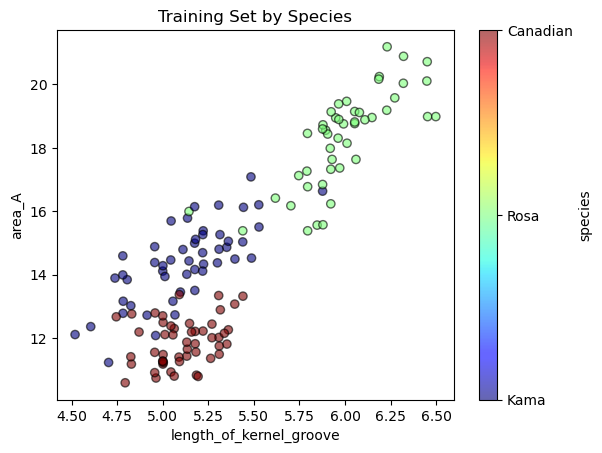

In [20]:
# Plot the training set
# Plot feature_1 vs feature_2 with Y being the color of the points
plt.scatter(X_pairs_train[feature_1], X_pairs_train[feature_2], c= Y_train_ordinal_encoded, edgecolors='k', cmap ='jet', alpha=0.6)

# Add some labels to this graph!
plt.title("Training Set by Species")
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.colorbar(ticks=[0,1,2], label='species').set_ticklabels(species_names)

plt.show() # This one is not necessary in Jupyter notebook, but is necessary to show the plot outside of interactive environments

In [21]:
# Initialize the Linear Model
model2 = LinearRegression()

# Fit the model to the training data
model2.fit(X_pairs_train, Y_train_encoded)

LinearRegression()

In [22]:
# Compute coefficients
coef_model2 = model2.coef_
intercept_model2 = model2.intercept_
print(coef_model2)
print(intercept_model2)

[[-1.37247828  0.17919278]
 [ 0.57293581  0.05419064]
 [ 0.79954247 -0.23338342]]
[ 5.09451267 -3.57234193 -0.52217075]


$$ \hat{Y}_{\text{Kama}} = 5.095 - 1.372X_{\text{length\_of\_kernel\_groove}} + 0.179X_{\text{Area}} $$

$$ \hat{Y}_{\text{Rosa}} = -3.572 + 0.573X_{\text{length\_of\_kernel\_groove}} + 0.054X_{\text{Area}} $$

$$ \hat{Y}_{\text{Canadian}} = -0.522 + 0.800X_{\text{length\_of\_kernel\_groove}} - 0.233X_{\text{Area}} $$

These decision equations define the classification process, with species boundaries determined by the relative influence of `area_A` and `length_of_kernel_groove`. Further refinements, such utilizing additional predictors, could help improve boundary separation.

In [23]:
# Predict the One-hot encoded targets for the test set
Y_test_pred2 = model2.predict(X_pairs_test)
Y_test_pred2[:10]

# This is the output for the predictions.

array([[-2.43282892e-01,  1.09904646e+00,  1.44236433e-01],
       [ 1.07950824e+00, -2.34851179e-01,  1.55342936e-01],
       [-4.65247837e-01,  1.11688837e+00,  3.48359470e-01],
       [ 9.52807095e-01,  2.05021679e-01, -1.57828774e-01],
       [ 4.80271736e-01,  5.91557639e-02,  4.60572501e-01],
       [ 8.03355240e-01,  2.00332914e-01, -3.68815340e-03],
       [-6.79425730e-03,  1.04805296e+00, -4.12586988e-02],
       [ 7.44823497e-01,  5.32047685e-02,  2.01971734e-01],
       [ 1.03296980e+00, -3.35423671e-02,  5.72569948e-04],
       [-6.32842616e-02,  2.42033515e-02,  1.03908091e+00]])

In [24]:
# Evaluate the model: Convert predictions back to class labels
# The predicted classes will correspond to the index of the max value in the one-hot vector
Y_test_pred2_classes = np.argmax(Y_test_pred2, axis=1)
Y_test_true_classes = np.argmax(Y_test_encoded, axis=1)
print('Predicted Classes:', Y_test_pred2_classes)
print('True Classes:', Y_test_true_classes)

Predicted Classes: [1 0 1 0 0 0 1 0 0 2 0 1 1 1 1 2 1 1 1 1 2 2 1 2 1 2 2 1 1 2 0 2 0 1 1 2 1
 0 1 1 0 1 1 2 2 2 0 2 0 0 2 0 2 0 2 1 2 0 2 2 1 0 0]
True Classes: [1 0 1 0 0 0 1 0 0 2 0 1 1 1 1 2 1 1 1 1 2 2 1 2 1 2 2 1 1 2 2 2 0 1 1 2 1
 0 1 0 2 1 1 2 2 2 0 2 0 0 0 0 2 0 2 1 0 0 2 2 1 0 0]


In [25]:
# Calculate training data accuracy
# Calculate test data accuracy
accuracy = accuracy_score(Y_test_pred2_classes, Y_test_true_classes)
print(f"Model Accuracy: {accuracy:.5f}")

Model Accuracy: 0.92063


In [26]:
print(classification_report(Y_test_pred2_classes, Y_test_true_classes))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       1.00      0.96      0.98        24
           2       0.90      0.90      0.90        20

    accuracy                           0.92        63
   macro avg       0.92      0.92      0.92        63
weighted avg       0.92      0.92      0.92        63



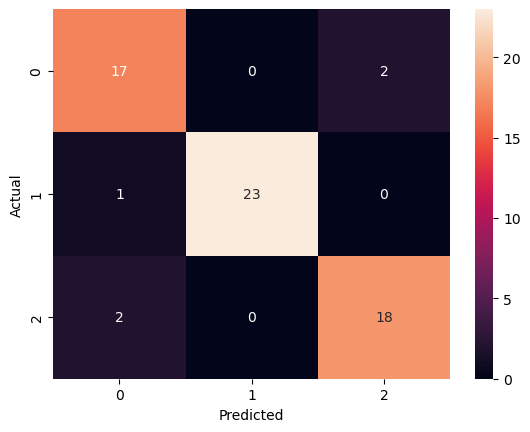

Accuracy: 0.9206349206349206
Macro Precision: 0.9176900584795322
Macro Recall: 0.9166666666666666
Weighted Precision: 0.9196254525201893
Weighted Recall: 0.9206349206349206
Micro Precision: 0.9206349206349206
Micro Recall: 0.9206349206349206


In [27]:
# Calculate confusion matrix
confusion_matrix = pd.crosstab(Y_test_pred2_classes, Y_test_true_classes, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)
plt.show()

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(Y_test_true_classes, Y_test_pred2_classes)
print(f'Accuracy: {accuracy}')

precision_macro = precision_score(Y_test_true_classes, Y_test_pred2_classes, average='macro')
recall_macro = recall_score(Y_test_true_classes, Y_test_pred2_classes, average='macro')

precision_weighted = precision_score(Y_test_true_classes, Y_test_pred2_classes, average='weighted')
recall_weighted = recall_score(Y_test_true_classes, Y_test_pred2_classes, average='weighted')

precision_micro = precision_score(Y_test_true_classes, Y_test_pred2_classes, average='micro')
recall_micro = recall_score(Y_test_true_classes, Y_test_pred2_classes, average='micro')

print(f'Macro Precision: {precision_macro}')
print(f'Macro Recall: {recall_macro}')
print(f'Weighted Precision: {precision_weighted}')
print(f'Weighted Recall: {recall_weighted}')
print(f'Micro Precision: {precision_micro}')
print(f'Micro Recall: {recall_micro}')

C:\Users\Sferg\miniconda3\envs\ds_env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


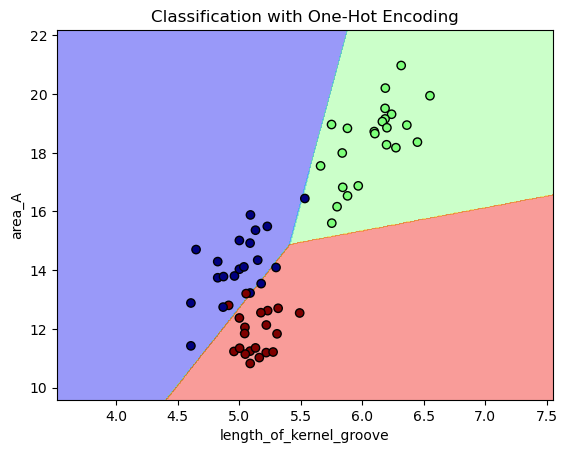

In [28]:
# Setting up the meshgrid for plotting decision boundaries
x1_min, x1_max = mydata[feature_1].min() - 1, mydata[feature_1].max() + 1
x2_min, x2_max = mydata[feature_2].min() - 1, mydata[feature_2].max() + 1
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 500), np.linspace(x2_min, x2_max, 500))

# Predict on meshgrid
Z = model2.predict(np.c_[xx1.ravel(), xx2.ravel()])
Z = np.argmax(Z, axis=1).reshape(xx1.shape)

# Plot decision boundaries and data points
plt.contourf(xx1, xx2, Z, alpha=0.4, levels=np.arange(-0.5, 2.5, 0.5), cmap=plt.cm.jet)
plt.scatter(X_pairs_test[feature_1], X_pairs_test[feature_2], c=Y_test_true_classes, edgecolors='k', cmap=plt.cm.jet)
plt.title("Classification with One-Hot Encoding")
plt.xlabel(feature_1)
plt.ylabel(feature_2)
plt.show()

In [29]:
# Determine if both features are important for predicting the label
# This is done by viewing the model summary
X_sm2 = sm.add_constant(X_pairs_train)

smodel = sm.OLS(Y_train_ordinal_encoded, X_sm2).fit()
print(smodel.summary())

                            OLS Regression Results                            
Dep. Variable:         kernel_species   R-squared:                       0.503
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     72.95
Date:                Fri, 07 Feb 2025   Prob (F-statistic):           1.32e-22
Time:                        12:50:44   Log-Likelihood:                -128.84
No. Observations:                 147   AIC:                             263.7
Df Residuals:                     144   BIC:                             272.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

## Part 2: Report

## **Linear Regression for Classification: Performance Evaluation on the Seeds Dataset**


### Dataset Selection and Preparation
The dataset is obtained from the UCI Machine Learning Repository: [Seeds Dataset - UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/236/seeds).
It was created as part of an agricultural study to classify wheat seeds into different varieties based on their 7 morphological features, measured using a soft X-Ray technique. The dataset was originally intended for classification tasks, making it well-suited for exploring how linear regression can be adapted for classification.

The dataset consists of 210 samples (70 samples per class) belonging to one of three classes. The classes (target variable) were the 3 varieties of wheat (Kama, Rosa, and Canadian wheat). 

Each sample represents a single wheat kernel, described by seven features:
- Area (A)
- Perimeter (P)
- Compactness (C) = 4πA / P²
- Length of Kernel
- Width of Kernel
- Asymmetry Coefficient
- Length of Kernel Groove

The target variable was originally encoded by integers, where
- 1 = Kama Wheat
- 2 = Rosa Wheat
- 3 = Canadian Wheat

However, because these are categorical variables, one-hot encoding was used to define these classes for the linear regression model.

### Data Preprocessing

The raw dataset presented several challenges that required preprocessing before analysis.

##### **Missing Column Headers:**
The dataset did not include column headers, causing the first row of data to be mistakenly identified as a header. This was corrected by specifying `header=None` during import.
##### **Data Misalignment upon Import Due to Extra Tabs:**
The dataset was tab-separated, but upon inspection of the raw .txt file, some rows contained multiple consecutive tabs, leading to misalignment when importing. This issue was resolved by setting whitespace as a delimiter during import, ensuring that multiple tabs were correctly interpreted as a single separator.
##### **Species Name Mapping:**
The dataset encoded wheat varieties as numerical labels (1, 2, 3), corresponding to Kama, Rosa, and Canadian wheat. For clarity in analysis and visualization, these numerical labels were mapped to their respective species names. However, since linear regression requires numerical target values, the species labels were later one-hot encoded, transforming them into a format suitable for regression-based classification.

Typically, linear regression is utilized to predict continuous values. However in this project,  I employed linear regression to a classification problem by utilizing one-hot encoding for categorical target variables.

The original dataset had target variables originally encoded 1, 2, or 3, corresponding to each wheat species. Using one-hot encoding, I converted the categorical target variables into three binary columns corresponding to each class.

  | Species | Original Encoding | One-Hot Encoding |
  |-------|-------|-------|
  | Kama   | [1]| [1, 0, 0] |
  | Rosa  | [2] | [0, 1, 0] |
  | Canadian | [3] | [0, 0, 1] |

##### **Train-Test-Split**
In order to evaluate the model's performance on unseen data, the dataset was divided into training and testing sets using a 70%-30% split; 70% of the data was used to train the model, while 30% was reserved for testing.

Keeping the test data separate ensured the model was not exposed to the test data during the training phase, which helps to prevent overfitting. The training set was used to fit the model and the test set was used to evaluate the performance of the model after training.

The random split was done using `train_test_split` from the `scikit-learn library`.

##### **Feature Selection**
To select the best features for the model, I initially used a Random Forest algorithm to assess feature importance. This allowed me to identify which predictors contributed most to the classification task. Additionally, I created pairwise plots to visually inspect how the features with the highest importance scores related to the target variable and each other. Specifically, I looked for the pairwise plot that illustrated the most separation between the classes. 

Based on these analyses, I chose two predictors to limit the model's complexity and focus on a clear visual representation of the data. I decided to use only two predictors as this allowed for a more manageable pairwise plot. However, I could have added more predictors and evaluated how they affected the model's performance.

## Model Implementation:
Since one-hot encoding was applied, the model creates separate equations for each species. Each equation shows how the input features relate to the encoded label for that species. The model then outputs continuous values, which estimate how likely each class (species) is for a given input. The class with the highest output value is chosen as the predicted class.


`LinearRegression()` from `scikit-learn` was used to determine the decision boundaries needed to classify new samples. The decision boundaries are defined as follows:

$$ \hat{Y}_{\text{Kama}} = 5.095 - 1.372X_{\text{length\_of\_kernel\_groove}} + 0.179X_{\text{Area}} $$

$$ \hat{Y}_{\text{Rosa}} = -3.572 + 0.573X_{\text{length\_of\_kernel\_groove}} + 0.054X_{\text{Area}} $$

$$ \hat{Y}_{\text{Canadian}} = -0.522 + 0.800X_{\text{length\_of\_kernel\_groove}} - 0.233X_{\text{Area}} $$

where $\beta_0$ is the intercept, and $\beta_1, \beta_2$ are the regression coefficients. Given a new input, the model computes three outputs, and the predicted class is: 

$$ \hat{Y} = \arg\max (\hat{Y}_{\text{Kama}}, \hat{Y}_{\text{Rosa}}, \hat{Y}_{\text{Canadian}})  $$

## Model Evaluation:

To assess model performance, Ordinary Least Squares (OLS) regression was used to analyze how well the input features predict the target variable. The OLS model is defined as follows:

$$
\hat{Y} = -4.6167 + 2.1720X_{\text{length\_of\_kernel\_groove}} - 0.4126X_{\text{Area}}
$$

Because the absolute value of the coefficient to length of kernel groove (2.172) is more than the absolute value of the coefficient to area (0.4126), it can be concluded that length of kernel groove is more important of a predictor than Area. However, both of these predictors are statistically significant to the classification problem, evidenced by their small (approaching 0) p-values.

Although the OLS $R^2$ value is only 0.504 despite a 92% classification accuracy, this is not directly related to classification performance. Since the output is categorical and $R^2$ measures how well independent variables explain variance in the target, this does not necessarily indicate poor classification performance. Performance metrics more relevant for classification include precision, recall, and accuracy.

The model achieved an accuracy of 92.06%, indicating that 92% of the seed samples were correctly classified based on the two predictor variables: `length_of_kernel_groove`  and `area_A`. This suggests that the model is highly effective in distinguishing between the three seed species.

The similarity between the macro, weighted, and micro measures suggests that the model does not favor one class over another. Class imbalances do not significantly affect model performance. 

Upon visual inspection of the confusion matrix, Rosa was the easiest species for the model to classify (high precision = 1.00 and recall = 0.96); almost all instances of Rosa were correctly identified. On the other hand, Kama has the highest number of misclassifications, slightly lower precision (0.85) and recall (0.89).

Despite this, the model performs very well across the three classes, with no extreme classification biases.

Using OLS, the p-value of the F-statistic is very small (1.32e-22) indicating that the model as a whole is statistically significant.

#### Limitations:
The dataset was small, with only 210 observations. A larger dataset would provide more robust insights and reduce the risk of the model capture dataset specific patterns rather than general trends.

The model relies on only two predictor variables. Although these features were chosen based on their performance, additional features would improve the predictive performance. It was shown (only in the code, but not explored in this discussion) that OLS with all 7 predictors yielded a prediction accuracy of 100%. There is a trade-off between prediction accuracy and model complexity. The best model would probably be somewhere between these two extremes (perhaps 3 or 4 predictors). 

Typically, logistic regression is preferred for classification tasks and a logistic regression model may perform better on the same data.

## Overcoming Challenges

Realizing that this was not just a notebook but a report I would be submitting for credit, I wanted to ensure it was well-structured and polished. To improve both this write-up and future ones, I set up JupyterLab IDE, which helped me stay more organized. Having multiple Jupyter notebooks easily accessible in separate tabs made it easier to reference the code examples provided by the instructor. Additionally, I installed useful extensions, such as Spellcheck and Variable Inspector. The latter was particularly helpful in keeping my variables organized and understanding their dimensionality and format — an area I had previously struggled with.

I had the code written for this project over a month ago. I **severely** underestimated the amount I would need to create the report -- I knew how to do the analyses, sure. But I didn't fully *understand* what I was doing until I was forced to organize it into a report. That was a whole different animal, and is why this project is several days late. I apologize for that, but I didn't want to submit anything other than my very best effort!

I surely learned a lot from this project. Handling errors, cleaning real data, organizing dozens of variables I defined, labeling those variables them intelligently), LaTEX format (ugh), and the hard lesson of budgeting more time to the write-up.